## Example script for training the L2HMC sampler

## Imports / setup for training

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
try:
    import horovod
    import horovod.tensorflow as hvd
    try:
        RANK = hvd.rank()
    except ValueError:
        hvd.init()
        
    RANK = hvd.rank()
    HAS_HOROVOD = True
    logging.info(f'Using horovod version: {horovod.__version__}')
    logging.info(f'Using horovod from: {horovod.__file__}')
    GPUS = tf.config.experimental.list_physical_devices('GPU')
    for gpu in GPUS:
        tf.config.experimental.set_memory_growth(gpu, True)
    if GPUS:
        gpu = GPUS[hvd.local_rank()]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
except ImportError:
    HAS_HOROVOD = False

import tensorflow as tf
from rich.console import Console
from rich.theme import Theme
from rich import print

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
    
sns.set_palette('bright')

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

plt.rc('text', usetex=True)

#console = Console(theme=Theme({"repr.number": "#ff79ff"}),
#                  force_jupyter=True, log_path=False,
#                  width=180, log_time=True, log_time_format='[%X]')

Duplicate key in file PosixPath('/home/foremans/.config/matplotlib/stylelib/dark_jupyter.mplstyle'), line 92 ('figure.facecolor: 474747')
Duplicate key in file PosixPath('/home/foremans/.config/matplotlib/stylelib/dark_jupyter.mplstyle'), line 93 ('figure.edgecolor: 0.50')


## Load configs from `BIN_DIR/train_configs.json`:

In [2]:
import json
from config import BIN_DIR

from utils.logger import Logger

logger = Logger()

train_configs_file = os.path.join(BIN_DIR, 'train_configs.json')
with open(train_configs_file, 'rt') as f:
    configs = json.load(f)
    
configs.update({
    'train_steps': 100000,
    'debug': False,
    'run_steps': 10000,
    'save_steps': 10000,
    'steps_per_epoch': 2000,
    'patience': 5,
    'min_lr': 1e-4,
    'logging_steps': 1000,
    'print_steps': 100,
    'beta_init': 5.,
    'beta_final': 5.,
})

configs['dynamics_config'].update({
    'num_steps': 7,
    'x_shape': [1024, 16, 16, 2],
    'net_weights': [1., 1., 1., 1., 1., 1.],
})

logger.log(configs)

tf.__version__: 2.5.0-rc3


[16:40:51]  {                                                                                
                'log_dir': None,                                                             
                'debug': False,                                                              
                'profiler': False,                                                           
                'md_steps': 10,                                                              
                'beta_init': 5.0,                                                            
                'beta_final': 5.0,                                                           
                'clip_val': 0.0,                                                             
                'loss_scale': 0.1,                                                           
                'hmc_steps': 0,                                                              
                'print_steps': 100,                                                          
                'logging_steps': 1000,                                                       
                'steps_per_epoch': 2000,                                                     
                'reduce_lr_factor': 0.99,                                                    
                'patience': 5,                                                               
                'min_lr': 0.0001,                                                            
                'save_steps': 10000,                                                         
                'run_steps': 10000,                                                          
                'train_steps': 100000,                                                       
                'dynamics_config': {                                                         
                    'verbose': True,                                                         
                    'eps': 0.1,                                                              
                    'num_steps': 7,                                                          
                    'hmc': False,                                                            
                    'use_ncp': True,                                                         
                    'eps_fixed': False,                                                      
                    'aux_weight': 0.0,                                                       
                    'plaq_weight': 0.0,                                                      
                    'charge_weight': 0.01,                                                   
                    'zero_init': False,                                                      
                    'separate_networks': True,                                               
                    'use_conv_net': True,                                                    
                    'use_mixed_loss': False,                                                 
                    'directional_updates': False,                                            
                    'combined_updates': False,                                               
                    'use_scattered_xnet_update': False,                                      
                    'use_tempered_traj': False,                                              
                    'gauge_eq_masks': False,                                                 
                    'x_shape': [1024, 16, 16, 2],                                            
                    'log_dir': None,                                                         
                    'optimizer': 'Nadam',                                                    
                    'net_weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                            
                },                                  

Get timestamp and create `log_dir` where everything will live

In [3]:
import utils.file_io as io
from utils.attr_dict import AttrDict

# Keep history of `log_dir` for later reference
log_file = os.path.join(os.getcwd(), 'log_dirs.txt')

configs = AttrDict(configs)

timestamps = AttrDict({
    'month': io.get_timestamp('%Y_%m'),
    'time': io.get_timestamp('%Y-%m-%d-%H%M%S'),
    'hour': io.get_timestamp('%Y-%m-%d-%H'),
    'minute': io.get_timestamp('%Y-%m-%d-%H%M'),
    'second': io.get_timestamp('%Y-%m-%d-%H%M%S'),
})

log_dir = io.make_log_dir(configs, 'GaugeModel', log_file,
                          timestamps=timestamps)
configs.log_dir = log_dir
io.write(f'{configs.log_dir}', log_file, 'a')

0 :: Using tensorflow version: 2.5.0-rc3
0 :: Using tensorflow from: /lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/tensorflow/__init__.py
0 :: Using horovod version: 0.21.3
0 :: Using horovod from: /lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/horovod/__init__.py
rank: 0 local_rank: 0 size: 1 local_size: 1


[16:40:56]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf7_actswish_bi5_bf5_dp01_sepNets_NCProj_ConvNets_bNorm_nw111111

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'UserWarning')
warnings.filterwarnings('ignore', 'CustomMaskWarning')
warnings.filterwarnings('ignore', 'WARNING:matplotlib')


## Run training:

To demonstrate that everything is working correctly, we only train for `configs.train_steps = 100` training steps.

In [6]:
plt.style.use('~/.matplotlib/stylelib/molokai.mplstyle')

[autoreload of utils.training_utils failed: Traceback (most recent call last):
  File "/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", l

[16:56:47]  Using separate (x, v)-networks for each LF step!!

[16:56:48]  Using separate (x, v)-networks for each LF step!!

[16:56:50]  dynamics.net_weights: NetWeights(x_scale=1.0, x_translation=1.0,                 
            x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)

[16:56:50]  Unable to save to `.json` file. Continuing...

──────────────────────────────── [2021-06-21 16:56] TRAINING ────────────────────────────────

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


───────────────────────── [2021-06-21 16:59] Running 10 MD updates ──────────────────────────

───────────────────────────────── [2021-06-21 16:59] done! ──────────────────────────────────

[16:59:54]  `get_title_str_from_params` took: 3.67e-05s  (0 min 3.6716461e-05 sec)

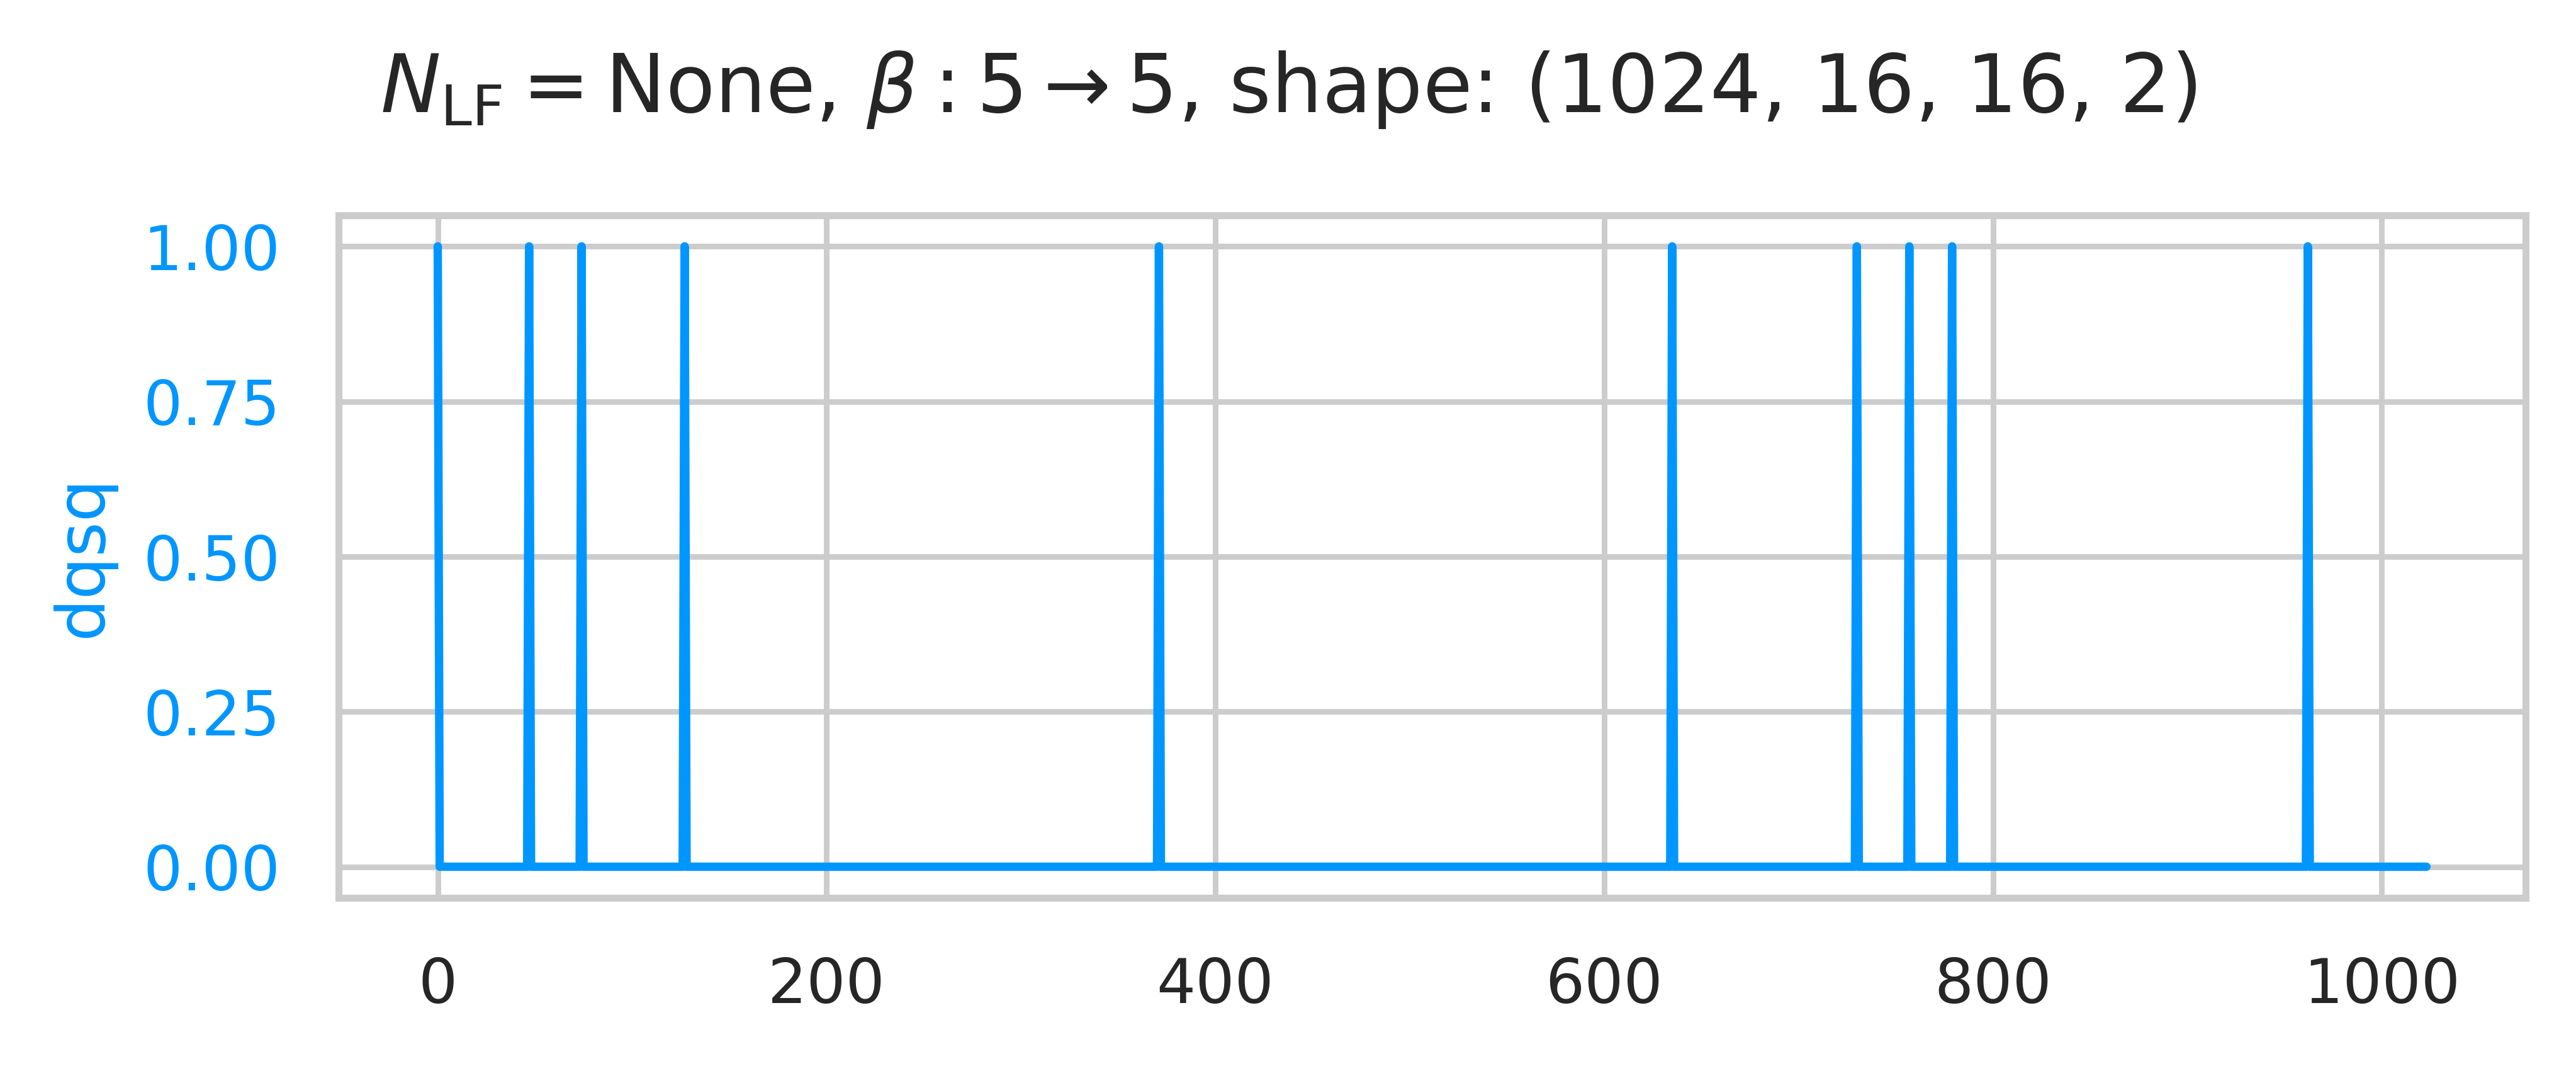

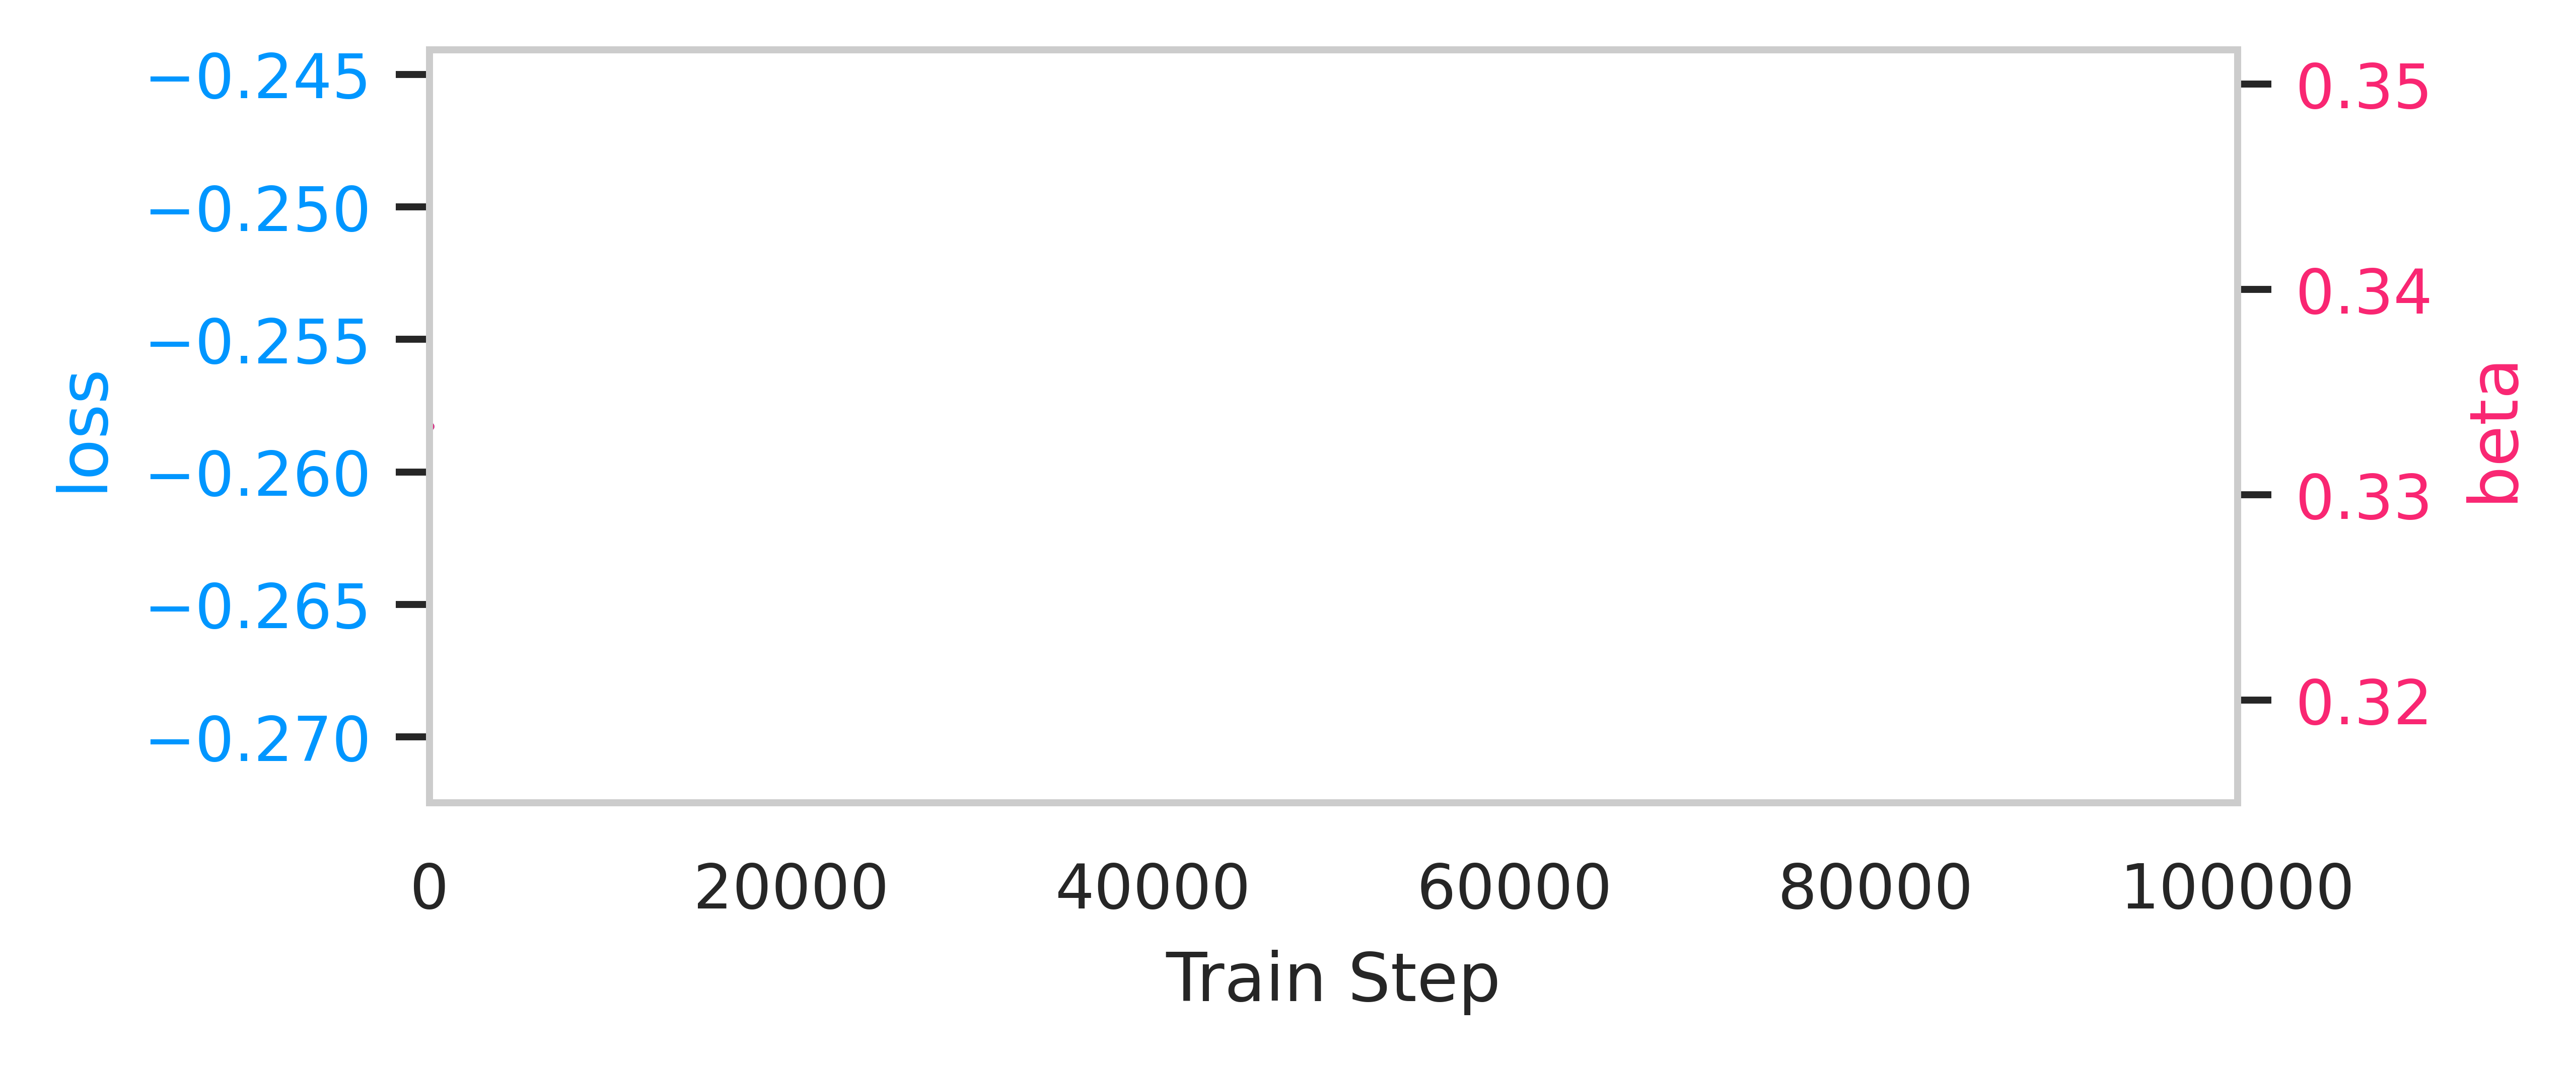

[16:59:55]  step=0/100001 dt=0.2301 loss=-15.48 accept_prob=0.6795 beta=5     xeps=0.1017    
            xeps_start=0.1019 xeps_mid=0.1017 xeps_end=0.1017 veps=0.1016 veps_start=0.1015  
            veps_mid=0.1017 veps_end=0.1017 Hwf_start=506   Hwf_mid=501.6 Hwf_end=506.1      
            Hwb_start=505.4 Hwb_mid=500.9 Hwb_end=505.5 dq_sin=0.261 charges=0.1309          
            sin_charges=0.1046 plaqs=0.08213 p4x4=-0.0001564

[17:00:21]  step=100/100001 dt=0.1907 loss=-0.6755 accept_prob=0.09584 beta=5                
            dq_int=1.311e-08 dq_sin=0.01225 plaqs=0.009202 p4x4=-0.003275

[17:00:42]  step=200/100001 dt=0.191 loss=-0.4407 accept_prob=0.1124 beta=5                  
            dq_int=8.128e-08 dq_sin=0.01126 plaqs=0.005226 p4x4=-0.002915

[17:01:03]  step=300/100001 dt=0.1905 loss=-0.4315 accept_prob=0.06235 beta=5                
            dq_int=1.192e-08 dq_sin=0.01078 plaqs=0.0005687 p4x4=-0.00368

[17:01:23]  step=400/100001 dt=0.1919 loss=-0.4771 accept_prob=0.08392 beta=5                
            dq_int=5.841e-08 dq_sin=0.009703 plaqs=-0.0004768 p4x4=-0.0004319

[17:01:44]  step=500/100001 dt=0.1952 loss=-0.3667 accept_prob=0.05685 beta=5                
            dq_int=3.695e-08 dq_sin=0.004367 plaqs=0.0008578 p4x4=-0.009888

[17:02:05]  step=600/100001 dt=0.1915 loss=-0.561 accept_prob=0.0665 beta=5                  
            dq_int=5.364e-08 dq_sin=0.01244 plaqs=0.002761 p4x4=0.008691

[17:02:26]  step=700/100001 dt=0.193 loss=-0.6385 accept_prob=0.1508 beta=5                  
            dq_int=2.84e-08 dq_sin=0.01052 plaqs=0.000903 p4x4=0.004375

[17:02:46]  step=800/100001 dt=0.1902 loss=-0.6634 accept_prob=0.1076 beta=5                 
            dq_int=2.98e-08 dq_sin=0.01126 plaqs=0.0003659 p4x4=-0.0005228

[17:03:07]  step=900/100001 dt=0.1985 loss=-0.9043 accept_prob=0.3003 beta=5                 
            dq_int=1.236e-07 dq_sin=0.0356 plaqs=6.19e-05 p4x4=-0.006118

[17:03:28]  step=1000/100001 dt=0.1926 loss=-1.579 accept_prob=0.2838 beta=5                 
            dq_int=9.847e-08 dq_sin=0.04878 plaqs=0.002623 p4x4=-0.001846

[17:03:54]  step=1100/100001 dt=0.1892 loss=-1.626 accept_prob=0.404 beta=5     dq_int=0.02  
            dq_sin=0.08603 plaqs=0.003142 p4x4=-0.003671

[17:04:15]  step=1200/100001 dt=0.191 loss=-1.768 accept_prob=0.4886 beta=5                  
            dq_int=2.398e-07 dq_sin=0.05913 plaqs=0.001193 p4x4=-0.007136

[17:04:35]  step=1300/100001 dt=0.1899 loss=-1.786 accept_prob=0.5808 beta=5                 
            dq_int=2.353e-07 dq_sin=0.05804 plaqs=-0.001409 p4x4=-0.00413

[17:04:56]  step=1400/100001 dt=0.1981 loss=-2.023 accept_prob=0.6343 beta=5                 
            dq_int=2.344e-07 dq_sin=0.1147 plaqs=0.001683 p4x4=-0.01123

[17:05:17]  step=1500/100001 dt=0.1923 loss=-2.087 accept_prob=0.6425 beta=5                 
            dq_int=2.423e-07 dq_sin=0.07203 plaqs=2.874e-05 p4x4=0.004684

[17:05:37]  step=1600/100001 dt=0.1915 loss=-2.083 accept_prob=0.6005 beta=5                 
            dq_int=2.652e-07 dq_sin=0.06544 plaqs=-0.002346 p4x4=-0.0002211

[17:05:58]  step=1700/100001 dt=0.2067 loss=-2.37 accept_prob=0.7384 beta=5                  
            dq_int=3.236e-07 dq_sin=0.1157 plaqs=-0.0004887 p4x4=-0.001368

[17:06:19]  step=1800/100001 dt=0.2022 loss=-2.014 accept_prob=0.7909 beta=5                 
            dq_int=3.737e-07 dq_sin=0.09162 plaqs=-0.001014 p4x4=-0.005379

[17:06:40]  step=1900/100001 dt=0.2002 loss=-2.384 accept_prob=0.7232 beta=5                 
            dq_int=3.157e-07 dq_sin=0.1092 plaqs=-0.0006442 p4x4=0.000546

[17:07:00]  step=2000/100001 dt=0.1923 loss=-2.399 accept_prob=0.7835 beta=5                 
            dq_int=4.247e-07 dq_sin=0.1137 plaqs=0.001093 p4x4=1.305e-05

[17:07:27]  step=2100/100001 dt=0.1957 loss=-3.137 accept_prob=0.7692 beta=5                 
            dq_int=3.441e-07 dq_sin=0.1224 plaqs=0.002377 p4x4=0.002672

[17:07:48]  step=2200/100001 dt=0.1933 loss=-3.015 accept_prob=0.7306 beta=5                 
            dq_int=3.084e-07 dq_sin=0.1216 plaqs=0.0007808 p4x4=0.009016

[17:08:09]  step=2300/100001 dt=0.1923 loss=-3.214 accept_prob=0.7925 beta=5                 
            dq_int=4.434e-07 dq_sin=0.1296 plaqs=-0.002635 p4x4=-0.006027

[17:08:30]  step=2400/100001 dt=0.1949 loss=-3.216 accept_prob=0.7776 beta=5     dq_int=0.02 
            dq_sin=0.1113 plaqs=-0.001442 p4x4=-0.001743

[17:08:51]  step=2500/100001 dt=0.1955 loss=-3.514 accept_prob=0.7917 beta=5     dq_int=0.02 
            dq_sin=0.1415 plaqs=0.001258 p4x4=-0.009737

[17:09:12]  step=2600/100001 dt=0.1954 loss=-3.813 accept_prob=0.8667 beta=5     dq_int=0.02 
            dq_sin=0.1598 plaqs=-4.234e-05 p4x4=0.01014

[17:09:33]  step=2700/100001 dt=0.1937 loss=-3.692 accept_prob=0.8081 beta=5     dq_int=0.02 
            dq_sin=0.1317 plaqs=0.0008841 p4x4=-0.002663

[17:09:54]  step=2800/100001 dt=0.1941 loss=-4.307 accept_prob=0.862 beta=5                  
            dq_int=3.953e-07 dq_sin=0.1137 plaqs=-0.00127 p4x4=-0.000196

[17:10:15]  step=2900/100001 dt=0.1936 loss=-4.046 accept_prob=0.8418 beta=5     dq_int=0.04 
            dq_sin=0.1418 plaqs=-0.000338 p4x4=0.01092

[17:10:36]  step=3000/100001 dt=0.1932 loss=-3.586 accept_prob=0.8627 beta=5     dq_int=0.02 
            dq_sin=0.1189 plaqs=-0.003098 p4x4=-0.002886

[17:11:03]  step=3100/100001 dt=0.1983 loss=-4.031 accept_prob=0.8536 beta=5     dq_int=0.04 
            dq_sin=0.1495 plaqs=-0.0008373 p4x4=-0.004056

[17:11:24]  step=3200/100001 dt=0.1905 loss=-4.048 accept_prob=0.8965 beta=5                 
            dq_int=3.997e-07 dq_sin=0.1529 plaqs=9.331e-05 p4x4=-0.0003681

[17:11:45]  step=3300/100001 dt=0.204 loss=-3.853 accept_prob=0.9039 beta=5                  
            dq_int=4.532e-07 dq_sin=0.1596 plaqs=-0.0009432 p4x4=0.008658

[17:12:06]  step=3400/100001 dt=0.1945 loss=-3.871 accept_prob=0.8996 beta=5                 
            dq_int=3.749e-07 dq_sin=0.1328 plaqs=-0.001631 p4x4=0.002157

[17:12:27]  step=3500/100001 dt=0.194 loss=-3.727 accept_prob=0.8861 beta=5     dq_int=0.02  
            dq_sin=0.1534 plaqs=0.0007491 p4x4=0.001039

[17:12:48]  step=3600/100001 dt=0.1951 loss=-3.695 accept_prob=0.868 beta=5                  
            dq_int=3.855e-07 dq_sin=0.1474 plaqs=-0.0002909 p4x4=-0.0002875

[17:13:09]  step=3700/100001 dt=0.1928 loss=-3.904 accept_prob=0.8838 beta=5                 
            dq_int=4.202e-07 dq_sin=0.1604 plaqs=3.769e-05 p4x4=0.004825

[17:13:30]  step=3800/100001 dt=0.196 loss=-4.01 accept_prob=0.8794 beta=5                   
            dq_int=3.773e-07 dq_sin=0.1469 plaqs=-0.002464 p4x4=0.0003473

[17:13:51]  step=3900/100001 dt=0.1969 loss=-4.277 accept_prob=0.8842 beta=5                 
            dq_int=4.055e-07 dq_sin=0.1492 plaqs=-0.0009755 p4x4=0.0002893

[17:14:13]  step=4000/100001 dt=0.194 loss=-3.848 accept_prob=0.8808 beta=5                  
            dq_int=3.645e-07 dq_sin=0.1599 plaqs=-0.0008363 p4x4=-0.00381

[17:14:40]  step=4100/100001 dt=0.1965 loss=-3.952 accept_prob=0.8614 beta=5     dq_int=0.06 
            dq_sin=0.1576 plaqs=0.002128 p4x4=-0.00821

[17:15:01]  step=4200/100001 dt=0.1959 loss=-3.94 accept_prob=0.8668 beta=5     dq_int=0.02  
            dq_sin=0.1579 plaqs=-0.001101 p4x4=0.006274

[17:15:22]  step=4300/100001 dt=0.1948 loss=-4.029 accept_prob=0.8845 beta=5                 
            dq_int=4.001e-07 dq_sin=0.1434 plaqs=0.002006 p4x4=0.001488

[17:15:43]  step=4400/100001 dt=0.1955 loss=-4.354 accept_prob=0.8907 beta=5     dq_int=0.02 
            dq_sin=0.1477 plaqs=0.0002838 p4x4=0.008495

[17:16:04]  step=4500/100001 dt=0.1965 loss=-3.994 accept_prob=0.903 beta=5     dq_int=0.04  
            dq_sin=0.1684 plaqs=0.002272 p4x4=-0.003863

[17:16:25]  step=4600/100001 dt=0.1985 loss=-4.008 accept_prob=0.8725 beta=5                 
            dq_int=3.843e-07 dq_sin=0.1377 plaqs=0.000149 p4x4=0.01235

[17:16:46]  step=4700/100001 dt=0.1964 loss=-3.726 accept_prob=0.8932 beta=5     dq_int=0.02 
            dq_sin=0.1122 plaqs=-0.002531 p4x4=0.0005616

[17:17:08]  step=4800/100001 dt=0.1946 loss=-4.136 accept_prob=0.9211 beta=5                 
            dq_int=4.396e-07 dq_sin=0.1401 plaqs=0.0002799 p4x4=-0.002899

[17:17:28]  step=4900/100001 dt=0.1919 loss=-3.996 accept_prob=0.8522 beta=5     dq_int=0.02 
            dq_sin=0.1437 plaqs=-0.0005857 p4x4=-0.004654

──────────────────────────────────── [2021-06-21 17:17]  ────────────────────────────────────

[17:17:49]  step=5000/100001 dt=0.1913 loss=-3.75 accept_prob=0.8826 beta=5     xeps=0.1089  
            xeps_start=0.08587 xeps_mid=0.1169 xeps_end=0.08559 veps=0.1091                  
            veps_start=0.07205 veps_mid=0.131 veps_end=0.07102 Hwf_start=393.2 Hwf_mid=393.6 
            Hwf_end=393.2 Hwb_start=391.9 Hwb_mid=392.3 Hwb_end=392   dq_sin=0.1437          
            charges=0.0009765 sin_charges=0.004963 plaqs=0.0001047 p4x4=4.903e-05

[17:18:15]  step=5100/100001 dt=0.1933 loss=-4.339 accept_prob=0.8774 beta=5     dq_int=0.04 
            dq_sin=0.1769 plaqs=0.002659 p4x4=0.002395

[17:18:36]  step=5200/100001 dt=0.1934 loss=-3.766 accept_prob=0.8808 beta=5                 
            dq_int=4.143e-07 dq_sin=0.1291 plaqs=0.0001735 p4x4=-0.001219

[17:18:57]  step=5300/100001 dt=0.1939 loss=-3.958 accept_prob=0.8952 beta=5                 
            dq_int=3.559e-07 dq_sin=0.1383 plaqs=0.002135 p4x4=-0.01006

[17:19:17]  step=5400/100001 dt=0.1948 loss=-3.922 accept_prob=0.9214 beta=5                 
            dq_int=3.195e-07 dq_sin=0.1672 plaqs=0.0004278 p4x4=-0.002042

[17:19:38]  step=5500/100001 dt=0.1963 loss=-4.194 accept_prob=0.8636 beta=5     dq_int=0.04 
            dq_sin=0.1383 plaqs=-0.0005914 p4x4=0.001421

[17:19:59]  step=5600/100001 dt=0.1951 loss=-3.944 accept_prob=0.849 beta=5                  
            dq_int=4.101e-07 dq_sin=0.1478 plaqs=0.000931 p4x4=-0.0004562

[17:20:20]  step=5700/100001 dt=0.1942 loss=-4.068 accept_prob=0.8909 beta=5                 
            dq_int=3.541e-07 dq_sin=0.144 plaqs=-0.0007602 p4x4=-0.001992

[17:20:41]  step=5800/100001 dt=0.196 loss=-4.116 accept_prob=0.8861 beta=5     dq_int=0.02  
            dq_sin=0.1092 plaqs=-0.001462 p4x4=0.01016

[17:21:03]  step=5900/100001 dt=0.1984 loss=-3.918 accept_prob=0.8902 beta=5     dq_int=0.02 
            dq_sin=0.1365 plaqs=-0.0005287 p4x4=-0.0001651

[17:21:25]  step=6000/100001 dt=0.1974 loss=-3.806 accept_prob=0.8877 beta=5     dq_int=0.02 
            dq_sin=0.1385 plaqs=5.626e-05 p4x4=0.004398

[17:21:52]  step=6100/100001 dt=0.1975 loss=-3.865 accept_prob=0.9204 beta=5     dq_int=0.02 
            dq_sin=0.1718 plaqs=0.0008076 p4x4=-0.001936

[17:22:12]  step=6200/100001 dt=0.1938 loss=-4.115 accept_prob=0.9225 beta=5     dq_int=0.02 
            dq_sin=0.1344 plaqs=-0.00115 p4x4=-0.001425

[17:22:33]  step=6300/100001 dt=0.1959 loss=-3.655 accept_prob=0.9003 beta=5                 
            dq_int=4.154e-07 dq_sin=0.1573 plaqs=-0.001376 p4x4=0.008125

[17:22:54]  step=6400/100001 dt=0.1963 loss=-4.808 accept_prob=0.9036 beta=5                 
            dq_int=4.117e-07 dq_sin=0.1271 plaqs=-0.001899 p4x4=-0.004023

[17:23:15]  step=6500/100001 dt=0.1931 loss=-4.121 accept_prob=0.8727 beta=5                 
            dq_int=3.87e-07 dq_sin=0.1552 plaqs=0.000509 p4x4=-0.003305

[17:23:36]  step=6600/100001 dt=0.1951 loss=-4.306 accept_prob=0.8758 beta=5                 
            dq_int=4.502e-07 dq_sin=0.127 plaqs=-0.0006395 p4x4=-0.0003209

[17:23:57]  step=6700/100001 dt=0.1945 loss=-3.887 accept_prob=0.8981 beta=5                 
            dq_int=3.786e-07 dq_sin=0.1557 plaqs=0.0009594 p4x4=-0.005583

[17:24:18]  step=6800/100001 dt=0.195 loss=-4.019 accept_prob=0.9314 beta=5                  
            dq_int=4.248e-07 dq_sin=0.1469 plaqs=-0.002404 p4x4=-0.007682

[17:24:39]  step=6900/100001 dt=0.1957 loss=-3.779 accept_prob=0.905 beta=5                  
            dq_int=4.105e-07 dq_sin=0.12  plaqs=0.0009298 p4x4=0.008486

[17:25:00]  step=7000/100001 dt=0.1971 loss=-3.937 accept_prob=0.8785 beta=5                 
            dq_int=3.772e-07 dq_sin=0.1291 plaqs=-0.000534 p4x4=0.005085

[17:25:27]  step=7100/100001 dt=0.1945 loss=-4.239 accept_prob=0.9064 beta=5                 
            dq_int=3.906e-07 dq_sin=0.1487 plaqs=-0.001242 p4x4=-0.005682

[17:25:48]  step=7200/100001 dt=0.1946 loss=-3.707 accept_prob=0.9058 beta=5                 
            dq_int=5.157e-07 dq_sin=0.1662 plaqs=0.001025 p4x4=-0.00212

[17:26:09]  step=7300/100001 dt=0.2001 loss=-4.135 accept_prob=0.886 beta=5     dq_int=0.04  
            dq_sin=0.1727 plaqs=-0.001422 p4x4=-0.007147

[17:26:30]  step=7400/100001 dt=0.1947 loss=-4.129 accept_prob=0.9285 beta=5                 
            dq_int=4.087e-07 dq_sin=0.1312 plaqs=-0.0008555 p4x4=0.01176

[17:26:51]  step=7500/100001 dt=0.195 loss=-4.24 accept_prob=0.8976 beta=5     dq_int=0.02   
            dq_sin=0.1803 plaqs=8.58e-05 p4x4=0.009909

[17:27:12]  step=7600/100001 dt=0.1954 loss=-3.975 accept_prob=0.8888 beta=5     dq_int=0.02 
            dq_sin=0.1244 plaqs=-0.001201 p4x4=0.0009064

[17:27:33]  step=7700/100001 dt=0.1942 loss=-3.996 accept_prob=0.9001 beta=5     dq_int=0.02 
            dq_sin=0.1636 plaqs=0.0001983 p4x4=0.01061

[17:27:54]  step=7800/100001 dt=0.1968 loss=-3.649 accept_prob=0.8598 beta=5                 
            dq_int=4.682e-07 dq_sin=0.1189 plaqs=0.001267 p4x4=0.006607

[17:28:15]  step=7900/100001 dt=0.194 loss=-3.94 accept_prob=0.8502 beta=5                   
            dq_int=3.347e-07 dq_sin=0.1295 plaqs=0.001224 p4x4=0.01196

[17:28:36]  step=8000/100001 dt=0.1941 loss=-3.996 accept_prob=0.8932 beta=5     dq_int=0.04 
            dq_sin=0.1571 plaqs=-0.001528 p4x4=-0.005504

[17:29:03]  step=8100/100001 dt=0.195 loss=-3.732 accept_prob=0.8738 beta=5                  
            dq_int=3.996e-07 dq_sin=0.1394 plaqs=0.0002084 p4x4=-0.01578

[17:29:24]  step=8200/100001 dt=0.1955 loss=-3.925 accept_prob=0.8993 beta=5     dq_int=0.02 
            dq_sin=0.1829 plaqs=0.000234 p4x4=-0.0009308

[17:29:45]  step=8300/100001 dt=0.1951 loss=-4.191 accept_prob=0.8483 beta=5                 
            dq_int=3.785e-07 dq_sin=0.1338 plaqs=0.0007725 p4x4=-0.006828

[17:30:06]  step=8400/100001 dt=0.1945 loss=-4.231 accept_prob=0.8749 beta=5     dq_int=0.02 
            dq_sin=0.1467 plaqs=0.0008514 p4x4=-0.003944

[17:30:27]  step=8500/100001 dt=0.1976 loss=-4.473 accept_prob=0.8725 beta=5     dq_int=0.04 
            dq_sin=0.1595 plaqs=0.001883 p4x4=0.003212

[17:30:48]  step=8600/100001 dt=0.1949 loss=-3.714 accept_prob=0.8664 beta=5     dq_int=0.02 
            dq_sin=0.1538 plaqs=-0.0002568 p4x4=-0.004431

[17:31:09]  step=8700/100001 dt=0.1969 loss=-3.874 accept_prob=0.9122 beta=5                 
            dq_int=3.662e-07 dq_sin=0.1498 plaqs=-0.0007273 p4x4=-0.005236

KeyboardInterrupt: 

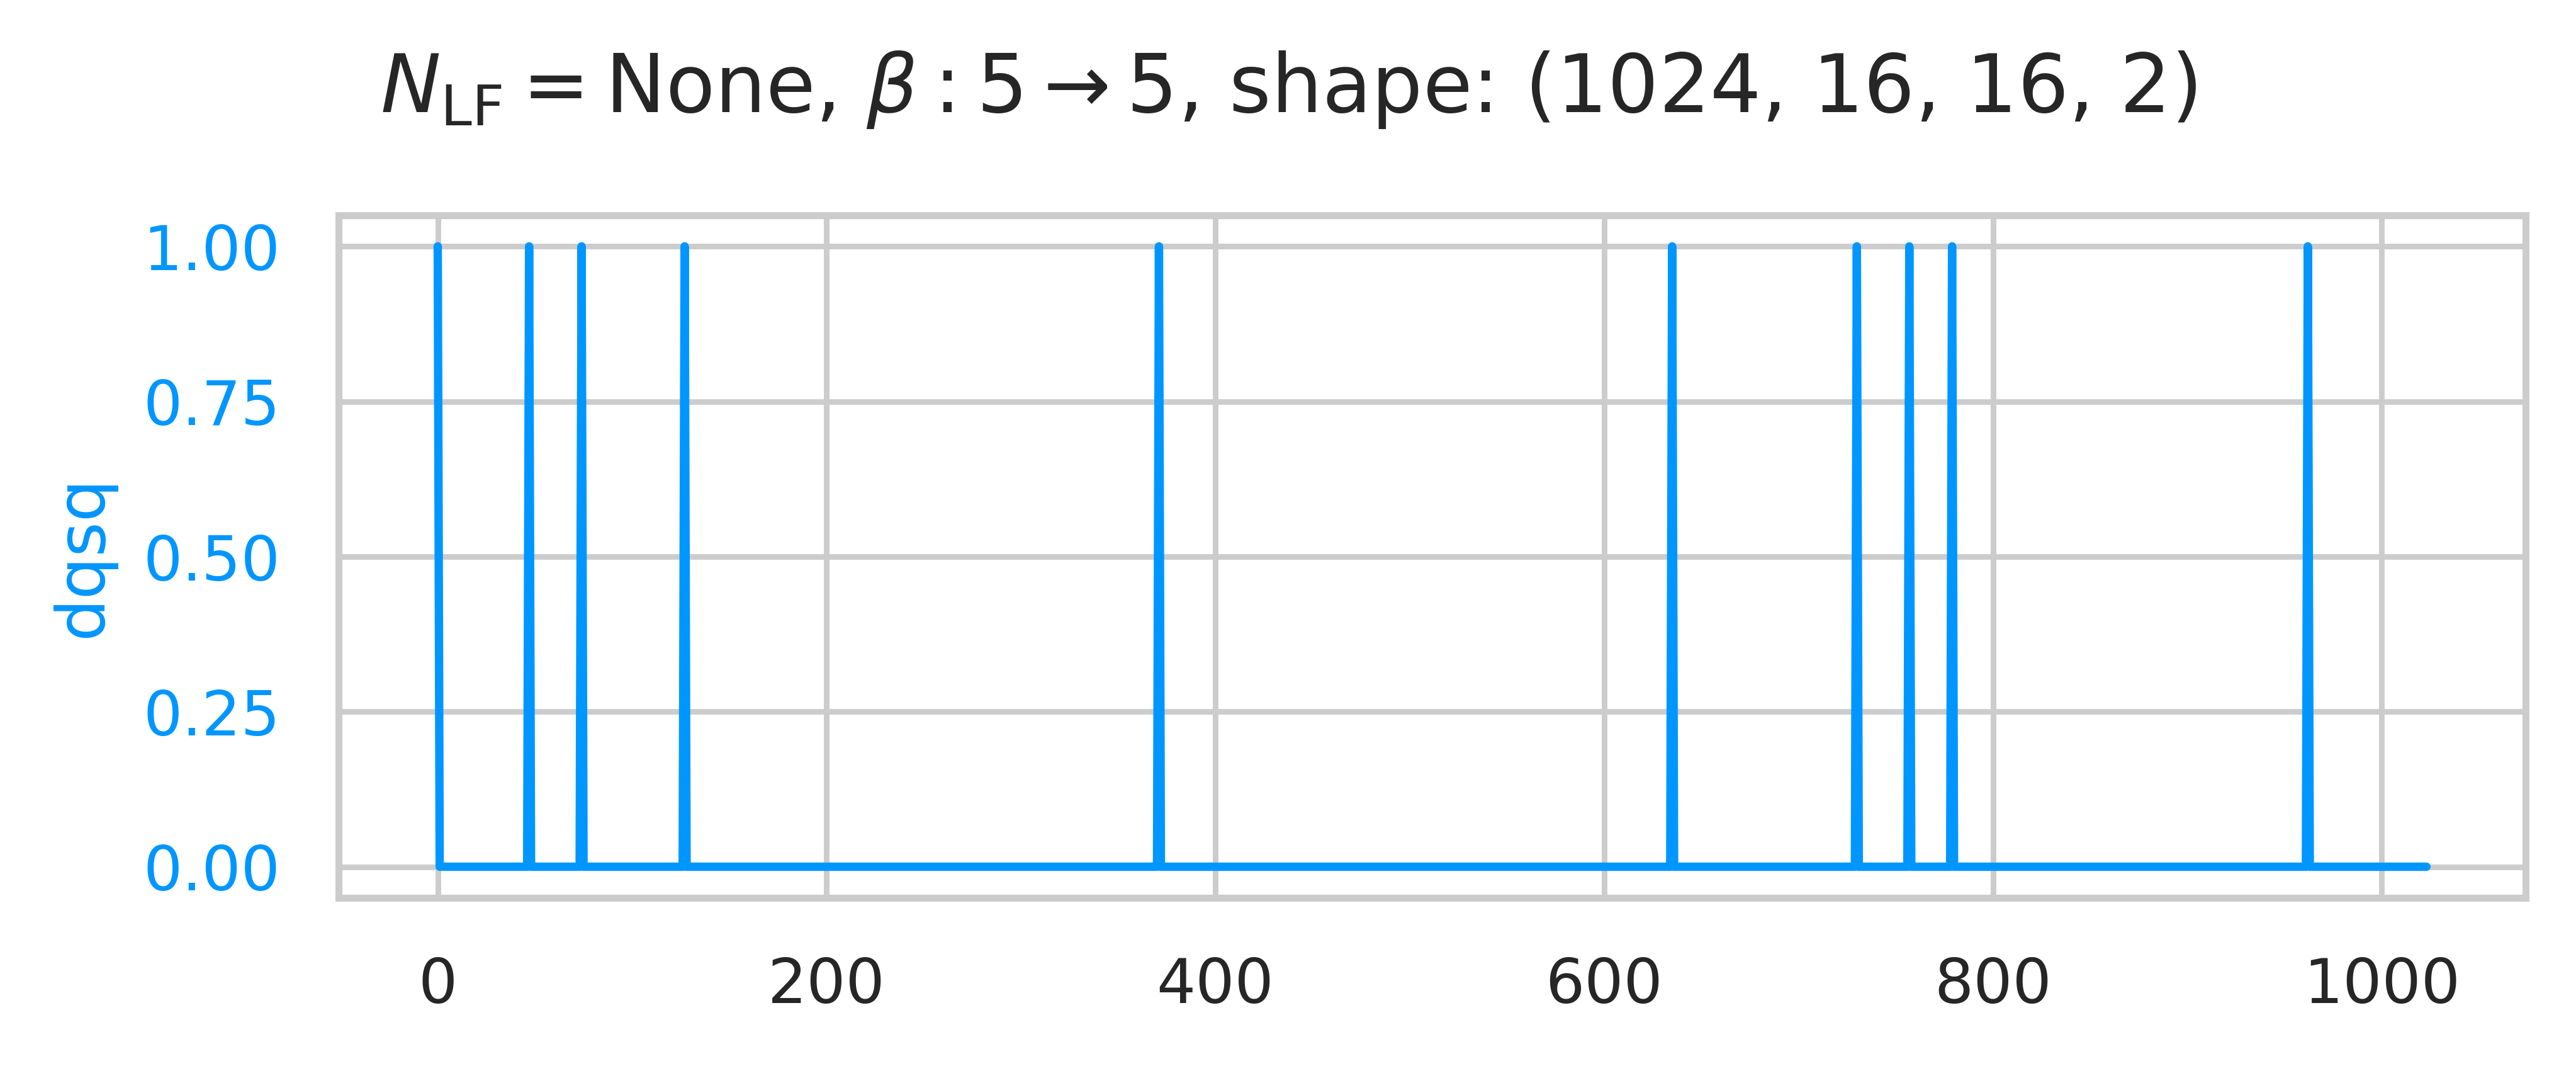

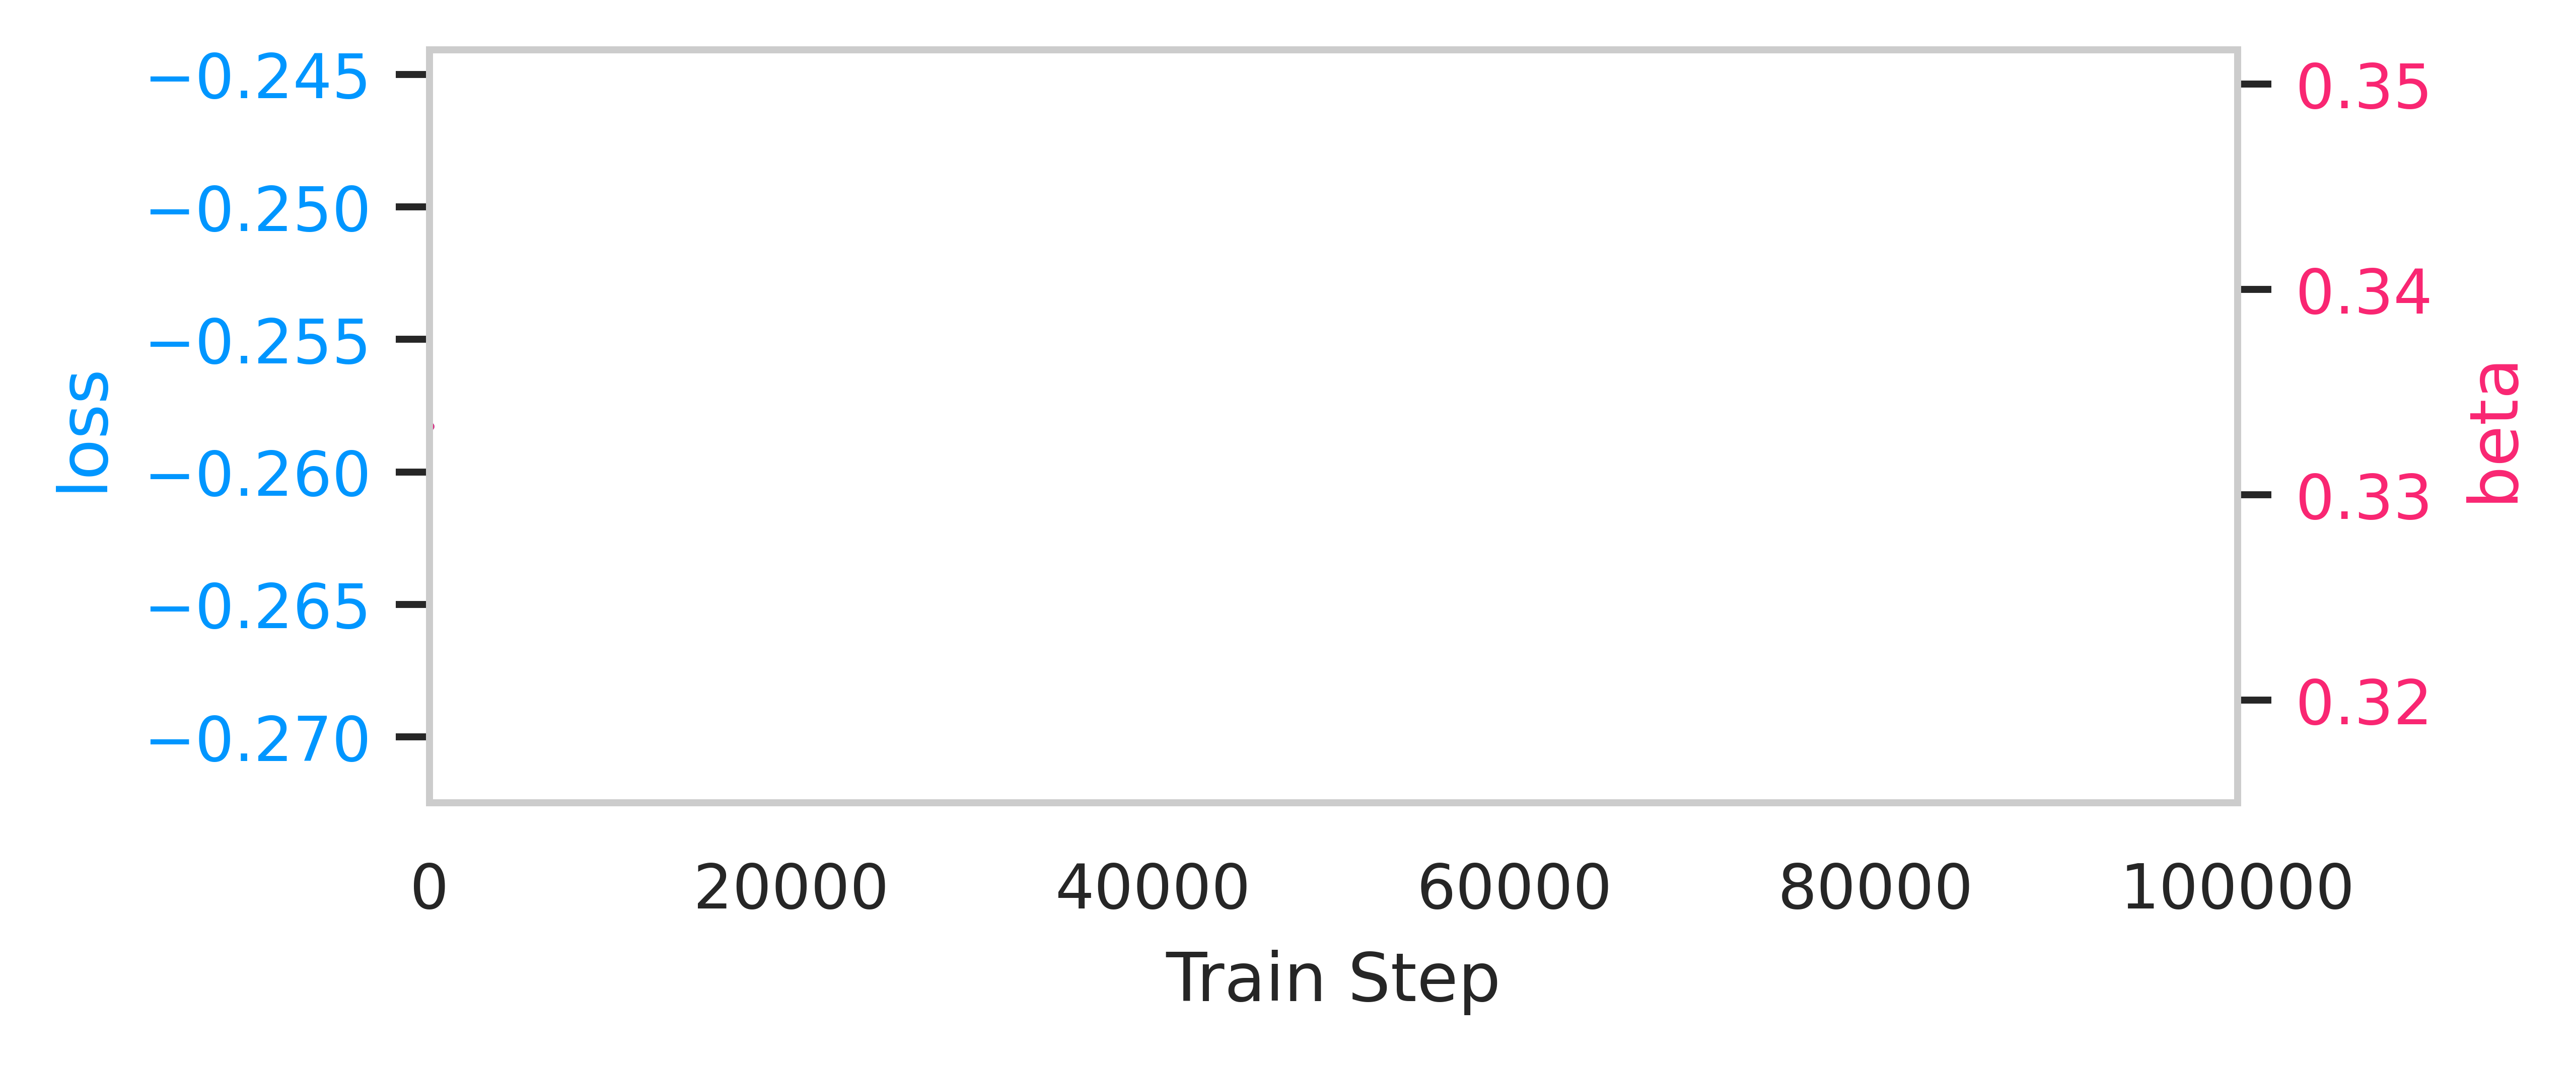

In [9]:
from utils.training_utils import train 

# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 12 

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=True,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

In [18]:
from utils.training_utils import train 

# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 4 

configs.train_steps = 251000
configs.beta_init = 2.
configs.beta_final = 5.

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=True,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

[10:42:48]  Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/2021_06/L16_b64_lf
            9_actswish_bi3_bf3_dp025_sepNets_NCProj_ConvNets_bNorm_nw111111/training/FLAGS.z.

            Using separate (x, v)-networks for each LF step!!

KeyboardInterrupt: 

### Make plots from training data

Explicitly, we look at the how the following quantities evolve during training:

1. The various stepsizes, $\varepsilon_{x},\, \varepsilon_{v}$

2. The error in the average plaquette: $\langle\delta\varphi_{P}\rangle \equiv \varphi_{P}^{*} - \langle\varphi_{P}\rangle$

where $\varphi_{P}^{*}$ is the exact result from the infinite volume limit, and is given by

\begin{equation}
\varphi_{P}^{*}(\beta) = \frac{I_{1}(\beta)}{I_{0}(\beta)}
\end{equation}

3. The error in the average $4\times4$ Wilson loop $\langle\mathcal{W}_{4\times4}\rangle$

4. The `sumlogdet`, overall Jacobian factor 

\begin{equation}
\sum\left|\mathcal{J}\right| = \left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|
\end{equation}
   

5. The acceptance probability 

\begin{equation}
A(\xi^{\prime}|\xi) = \min\left\{1, \frac{p(\xi^{\prime})}{p(\xi)}\left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|\right\}
\end{equation}

6. The integer-valued topological charge 

\begin{align}
\mathcal{Q}_{\mathbb{Z}} &\equiv \frac{1}{2\pi}\sum_{P}\left\lfloor\varphi_{P}\right\rfloor, \\
\left\lfloor\varphi_{P}\right\rfloor &\equiv \varphi_{P} - 2\pi\left\lfloor\frac{\varphi_{P}+\pi}{2\pi}\right\rfloor
\end{align}
   

7. The tunneling rate(s)  
\begin{equation}
    \delta_{\mathcal{Q}_{\mathcal{X}}}(\xi^{\prime}, \xi) \equiv |\mathcal{Q}_{\mathcal{X}}^{\prime} -  \mathcal{Q}_{\mathcal{X}}|
\end{equation}

for $\mathcal{X} \in \left\{\mathbb{R}, \mathbb{Z}\right\}$.

8. The loss 

\begin{equation}
\mathcal{L}_{\theta}(\xi, \xi^{\prime}, A(\xi^{\prime}|\xi)) 
= -A(\xi^{\prime}|\xi)\cdot \ell(\xi^{\prime},\xi)
\end{equation}

with

\begin{equation}
\ell(\xi, \xi^{\prime}) \equiv \frac{(\mathcal{Q}^{\prime}_{\mathbb{R}} - \mathcal{Q}_{\mathbb{R}})^{2}}{a^2} 
\end{equation}

and

\begin{equation}
\mathcal{Q}_{\mathbb{R}}(\varphi) = \frac{1}{2\pi}\sum_{P}\sin\varphi_{P}
\end{equation}

so

\begin{align}
\begin{split}
\mathcal{L}_{\theta} &= -A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi a)^{2}}\left(%
 \mathcal{Q}_{\mathbb{R}}(\varphi^{\prime}) - \mathcal{Q}_{\mathbb{R}}(\varphi)\right)^{2} \\
 &=-A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi\,a)^2}\left(\sum_{P}\sin\varphi_{P}^{\prime} - \sum_{P}\sin\varphi_{P}\right)^{2}
 \end{split}
 \end{align}

In [13]:
from utils.plotting_utils import set_size, make_ridgeplots

num_chains_to_plot = 16

to_plot = [
    'xeps', 'veps',
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


train_dataset = train_data.get_dataset(therm_frac=0.)
for key, val in train_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
ax.plot(configs['logging_steps'] * np.arange(len(train_dataset.loss)), train_dataset.loss)
ax1 = ax.twinx()

ax1.plot()


ax.set_ylabel(f'Loss')
ax.grid(True, alpha=0.4)
ax.set_xlabel(f'Training step')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
from utils.plotting_utils import make_ridgeplots
fig, ax = make_ridgeplots(train_dataset, num_chains_to_plot)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[09:54:46]  `make_ridgeplots` took: 22.2s  (0 min 22.158016 sec)

## Run inference using the trained model (`dynamics` object):

In [11]:
from utils.inference_utils import run as run_inference

if configs.get('run_steps', None) > 0:
    configs.run_steps = 5000
    log_dir = configs.log_dir
    beta = configs.get('beta_final', None)
    inference_results = run_inference(dynamics=dynamics,  # pass the trained dynamics
                                      x=x,
                                      args=configs, 
                                      beta=beta,
                                      make_plots=True,
                                      therm_frac=0.,
                                      num_chains=64,
                                      #console=console,
                                      save_x=False)

Reducing `num_chains` from: 64 to 16.


[22:06:28]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/run_data

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/summaries

            Compiled `dynamics.test_step` using tf.function!

            Running inference with:                                                          
             beta: 5.0                                                                       
            net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0,    
            v_scale=1.0, v_translation=1.0, v_transformation=1.0)

[22:07:48]  step:     0/5000  dt=0.02967 loss=-5.267 accept_prob=0.2015 beta=5     Hwf=419.6 
            Hwb=418.2 p4x4f=-0.0005351 p4x4b=-0.0007017 dq_int=1.907e-07 dq_sin=0.06143      
            sin_charges=-0.0537 plaqs=0.006493 p4x4=-0.01321

[22:08:16]  step:  1000/5000  dt=0.02371 loss=-2.811 accept_prob=0.1782 beta=5     Hwf=410.4 
            Hwb=410.9 p4x4f=-0.0006246 p4x4b=-0.0004745 dq_int=0.1   dq_sin=0.07214          
            sin_charges=-0.2295 plaqs=-0.002525 p4x4=0.0128

[22:08:44]  step:  2000/5000  dt=0.021 loss=-2.969 accept_prob=0.4569 beta=5     Hwf=410.1   
            Hwb=409.3 p4x4f=-0.000229 p4x4b=-0.0008853 dq_int=0.2   dq_sin=0.2155            
            sin_charges=0.1992 plaqs=0.002194 p4x4=-0.007586

[22:09:11]  step:  3000/5000  dt=0.02355 loss=-2.403 accept_prob=0.2727 beta=5     Hwf=410.3 
            Hwb=409.7 p4x4f=-3.29e-05 p4x4b=-0.0002274 dq_int=4.172e-08 dq_sin=0.05625       
            sin_charges=-0.05259 plaqs=-0.0002328 p4x4=-0.009021

[22:09:39]  step:  4000/5000  dt=0.02098 loss=-2.133 accept_prob=0.2065 beta=5     Hwf=409.9 
            Hwb=410.8 p4x4f=-0.0009775 p4x4b=-6.981e-05 dq_int=8.345e-08 dq_sin=0.03893      
            sin_charges=0.1106 plaqs=0.002389 p4x4=0.02169

[22:10:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/tint_vs_draws.pdf

            `plot_autocorrs_vs_draws` took: 5.78s  (0 min 5.7822597 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots

            `get_title_str_from_params` took: 1.86e-05s  (0 min 1.8596649e-05 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/mcmc_lineplots

[22:10:15]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/xarr_plots

            time spent plotting loss: 0.32648420333862305

[22:10:16]  time spent plotting accept_prob: 0.5768234729766846

            time spent plotting xeps: 0.5259840488433838

[22:10:17]  time spent plotting veps: 0.5270764827728271

            time spent plotting sumlogdetf: 0.5736587047576904

[22:10:18]  time spent plotting sumlogdetb: 0.5713798999786377

            time spent plotting accept_probf: 0.5748107433319092

[22:10:19]  time spent plotting accept_probb: 0.5804612636566162

[22:10:20]  time spent plotting Hf: 0.7298612594604492

            time spent plotting Hb: 0.7299418449401855

[22:10:21]  time spent plotting logdetsf: 0.7425751686096191

[22:10:22]  time spent plotting logdetsb: 0.7356305122375488

[22:10:23]  time spent plotting Hwf: 0.7354118824005127

            time spent plotting Hwb: 0.7421379089355469

[22:10:24]  time spent plotting xepsf: 0.5218837261199951

[22:10:25]  time spent plotting xepsb: 0.5293803215026855

            time spent plotting vepsf: 0.5276727676391602

[22:10:26]  time spent plotting vepsb: 0.5322751998901367

            time spent plotting sinQf: 0.7017824649810791

[22:10:27]  time spent plotting sinQb: 0.6981222629547119

[22:10:28]  time spent plotting intQf: 0.7045986652374268

[22:10:29]  time spent plotting intQb: 0.7021751403808594

            time spent plotting plaqsf: 0.7396583557128906

[22:10:30]  time spent plotting plaqsb: 0.736177921295166

[22:10:31]  time spent plotting p4x4f: 0.7085814476013184

            time spent plotting p4x4b: 0.7049164772033691

[22:10:32]  time spent plotting accept_mask: 0.5755784511566162

[22:10:33]  time spent plotting sumlogdet: 0.572636604309082

            time spent plotting sumlogdet_prop: 0.5754663944244385

[22:10:34]  time spent plotting dq_int: 0.5708467960357666

            time spent plotting dq_sin: 0.5730185508728027

[22:10:35]  time spent plotting charges: 0.5842678546905518

[22:10:36]  time spent plotting sin_charges: 0.5799524784088135

            time spent plotting p4x4: 0.5870487689971924

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:10:45]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:10:55]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:05]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/logdetsf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:14]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/logdetsb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:23]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hwf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:33]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/Hwb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:42]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/sinQf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:11:51]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/sinQb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:00]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/intQf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:09]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/intQb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:19]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/plaqsf_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:28]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/plaqsb_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:37]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/p4x4f_ridgeplot.pdf.

/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/lus/grand/projects/DLHMC/tf2.5.0-rc3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


[22:12:47]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/xarr_plots/ridgeplots/p4x4b_ridgeplot.pdf.

            `make_ridgeplots` took: 10.9s  (2 min 10.864785 sec)

[22:15:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/energy_dists_traj.pdf.

            `savefig` took: 0.476s  (0 min 0.4756124 sec)

            `plot_energy_distributions` took: 26.3s  (2 min 26.265684 sec)

            Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/plots/avg_lineplots

            Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/loss_avg.pdf.

[22:15:14]  `savefig` took: 0.385s  (0 min 0.38531065 sec)

[22:15:34]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/accept_prob_avg.pdf.

[22:15:35]  `savefig` took: 0.393s  (0 min 0.39275861 sec)

[22:15:59]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/Hwf_avg.pdf.

            `savefig` took: 0.406s  (0 min 0.40550256 sec)

[22:16:24]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/Hwb_avg.pdf.

            `savefig` took: 0.396s  (0 min 0.39598012 sec)

[22:16:48]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4f_avg.pdf.

            `savefig` took: 0.398s  (0 min 0.39849043 sec)

[22:17:12]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4b_avg.pdf.

            `savefig` took: 0.392s  (0 min 0.39237261 sec)

[22:17:37]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/dq_int_avg.pdf.

            `savefig` took: 0.415s  (0 min 0.41464663 sec)

[22:18:02]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/dq_sin_avg.pdf.

            `savefig` took: 0.404s  (0 min 0.40356541 sec)

[22:18:26]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/charges_avg.pdf.

            `savefig` took: 0.404s  (0 min 0.40398526 sec)

[22:18:49]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/sin_charges_avg.pdf.

[22:18:50]  `savefig` took: 0.39s  (0 min 0.38960242 sec)

[22:19:13]  Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/avg_lineplots/p4x4_avg.pdf.

            `savefig` took: 0.376s  (0 min 0.37598991 sec)

            `mcmc_avg_lineplots` took: 59.9s  (3 min 59.940821 sec)

            Saving figure to: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021_0
            6/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b1024
            __lf9_eps005-2021-06-15-2206/plots/charge_chains.pdf.

[22:19:14]  `savefig` took: 0.205s  (0 min 0.20490336 sec)

            `plot_charges` took: 0.232s  (0 min 0.23158693 sec)

            `plot_data` took: 6.38s  (9 min 6.3767157 sec)

[22:20:29]  Appending inference results to                                                   
            /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/inference.csv.

[22:24:35]  Creating directory: /lus/grand/projects/DLHMC/l2hmc-qcd/logs/GaugeModel_logs/2021
            _06/L16_b1024_lf9_actswish_bi3_bf5_dp01_sepNets_NCProj_nw111111/inference/L16_b10
            24__lf9_eps005-2021-06-15-2206/profile_info

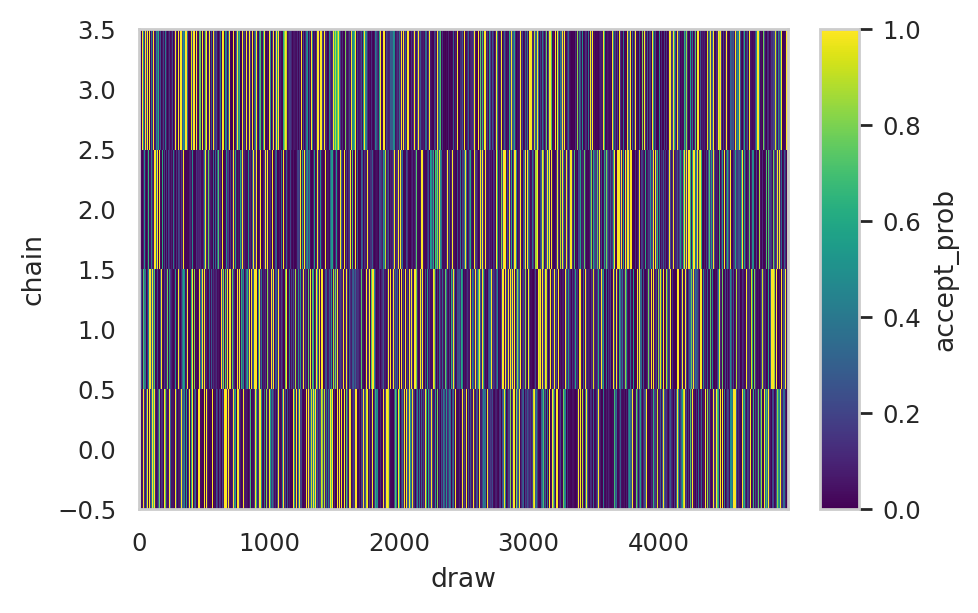

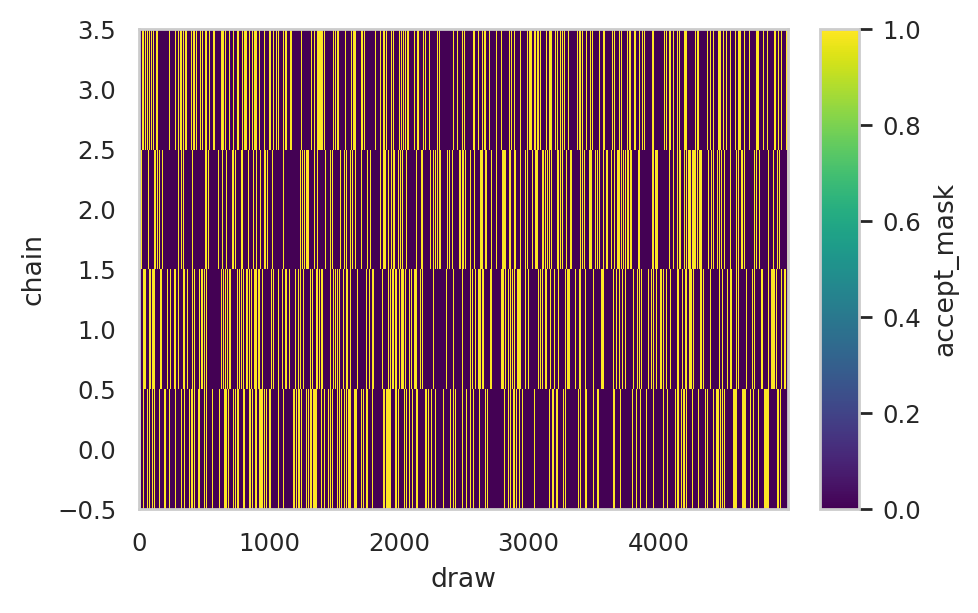

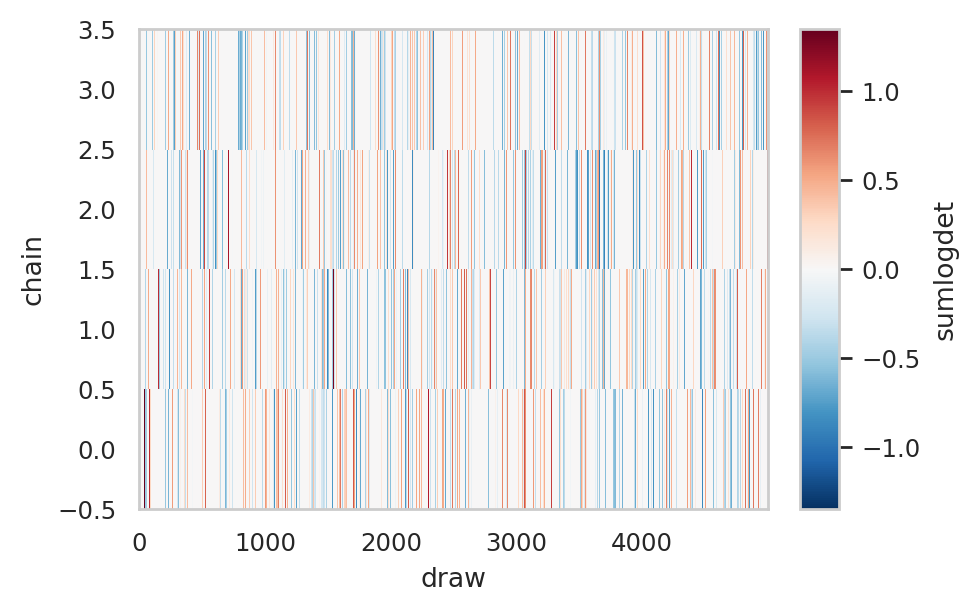

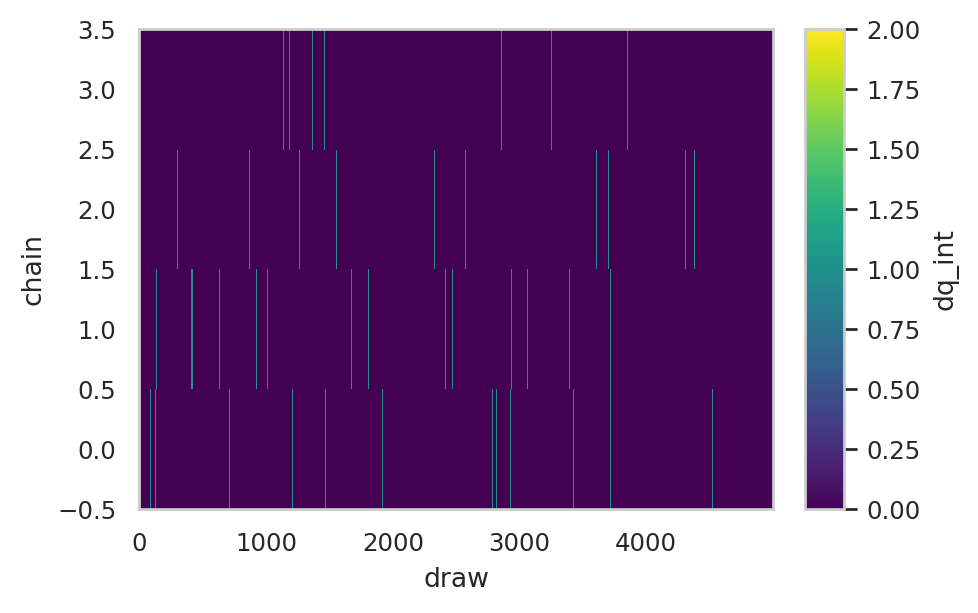

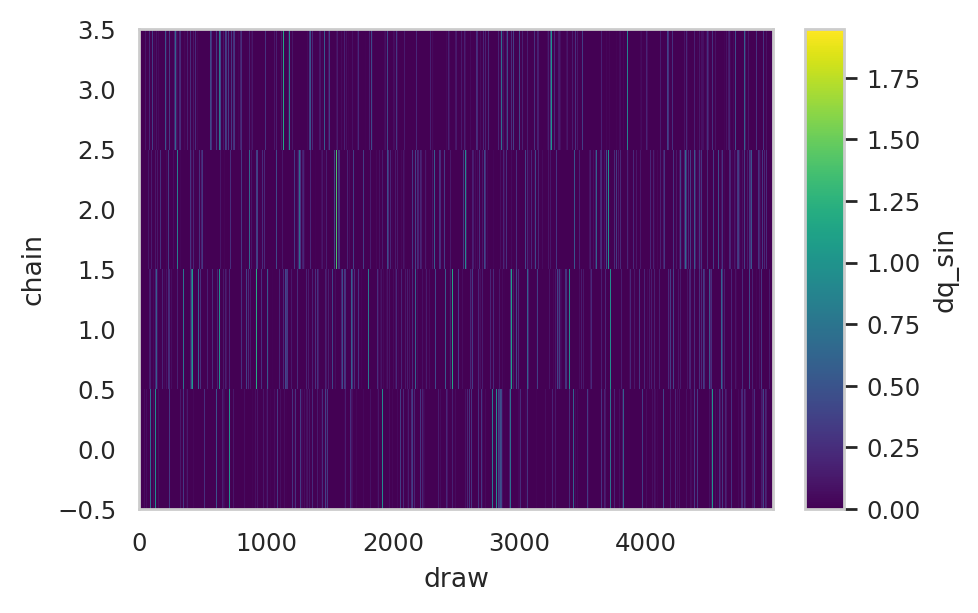

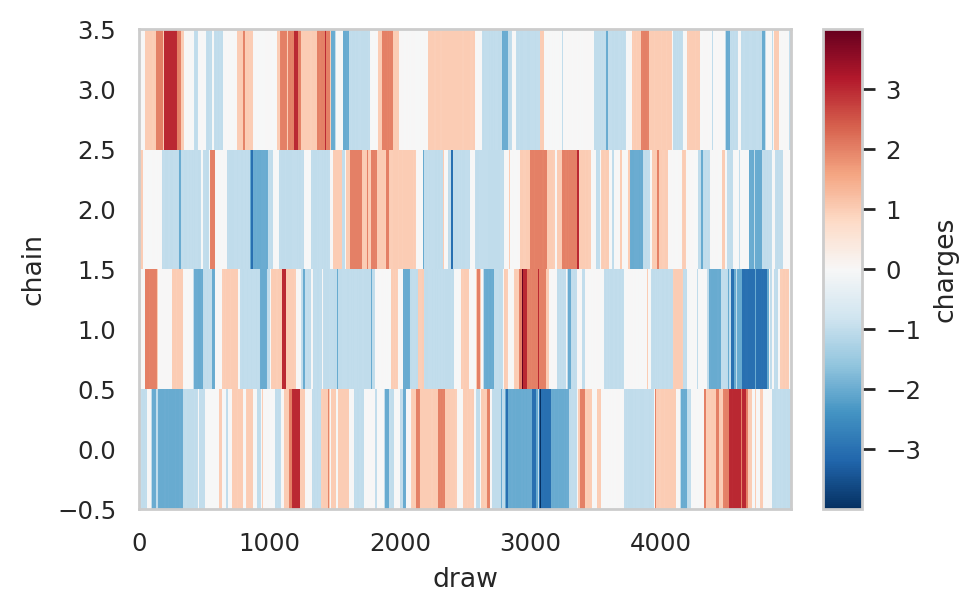

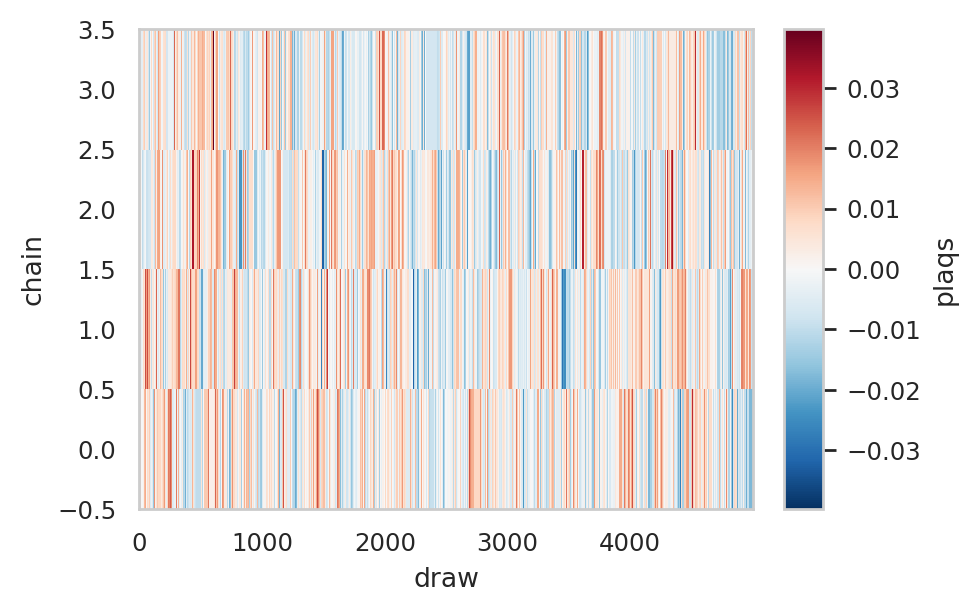

In [15]:
from utils.plotting_utils import set_size, make_ridgeplots

num_chains_to_plot = 4 

to_plot = [
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


run_data = inference_results.run_data

run_dataset = run_data.get_dataset(therm_frac=0.)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

In [ ]:
# only make plots for 8 chains to speed up plotting
num_chains_to_plot = 64 

# draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', none)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=true,
                                         num_chains=num_chains_to_plot,
                                         should_track=false)

In [ ]:
num_chains_to_plot = 16

run_dataset = inference_results.run_data.get_dataset(therm_frac=0.1)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)
    
_ = make_ridgeplots(run_dataset, num_chains_to_plot)